# Lab Assignment Three: Extending Logistic Regression

### Authors
- Juliana Antonio
- Xiaona Hang
- Chuanqi Deng


## 1. Preparation and Overview

The "Body Performance Data" sourced from the [Korea Sports Promotion Foundation](https://www.bigdata-culture.kr/bigdata/user/data_market/detail.do?id=ace0aea7-5eee-48b9-b616-637365d665c1), available on Kaggle, comprises 13,393 rows and encompasses 12 features, such as age, gender, height, weight, and more. This dataset, meticulously curated, demonstrates the correlation between age and various exercise performance metrics, thereby providing insights into individual performance grades.

Utilizing this rich dataset, the aim is to classify individuals into distinct performance grades: A (Best), B, C, and D (Worst), based on the aforementioned 12 features. This classification is pivotal for tailoring personalized training plans, catering to diverse needs and abilities. Consequently, gyms and rehabilitation centers stand to benefit significantly from leveraging predictive analytics to craft bespoke training plans, optimizing clients' progress and well-being.

Beyond professional institutions, individuals themselves will be interested in understanding their body performance classification. Armed with this knowledge, they can make informed decisions regarding their fitness journey, setting realistic goals and embracing tailored approaches for holistic improvement.

The deployment of a robust classification model is expected to achieve an accuracy of approximately 80%. By meeting this benchmark, the model ensures reliable predictions, empowering stakeholders to make data-driven decisions with confidence.

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

raw_data = pd.read_csv("data/bodyPerformance.csv")

# preprocessing
data = pd.get_dummies(raw_data, columns=['gender'],dtype=np.int8) # one-hot encoding for gender
labels = data['class'].map(lambda c: ord(c) - ord('A')) # encode lables into integer
data.drop(['class'], axis=1, inplace=True) # remove class column

# scale
scaler = StandardScaler()
features = scaler.fit_transform(data)

# PCA
pca = PCA(8)
pca_feature = pca.fit_transform(features)
raw_data.shape, pca_feature.shape

((13393, 12), (13393, 8))

The dataset has one categorical feature, the gender. One-hot encoding is enployed to convert it into numerical data. Next, the lables/class is moved to another separate variable, lables. Then, the Standard Scaling and PCA are applied to mitigate the difference of multiple features reduce the number of features from 12 to 8.

In [31]:
# breakdown of the variables
pd.DataFrame(pca_feature).describe()

,0,1,2,3,4,5,6,7
count,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04
mean,-7.627240e-17,-1.276595e-18,-4.428292e-17,1.819562e-17,-3.309199e-17,9.789990e-18,-6.697978e-18,2.044469e-17
std,2.386378e+00,1.462662e+00,1.127011e+00,9.438121e-01,8.081770e-01,5.785046e-01,5.602344e-01,4.860709e-01
min,-5.041796e+00,-5.384663e+00,-7.437324e+00,-4.140902e+00,-4.012083e+00,-2.242237e+00,-5.062883e+00,-2.246422e+00
25%,-1.967484e+00,-1.012307e+00,-6.911124e-01,-6.042082e-01,-4.971976e-01,-3.845767e-01,-3.517389e-01,-3.142285e-01
50%,-8.995369e-01,1.073930e-01,5.143689e-02,1.506179e-02,7.247022e-03,1.665698e-02,8.867419e-03,-3.037003e-03
75%,2.360703e+00,1.072822e+00,7.628835e-01,6.133066e-01,5.253231e-01,3.905508e-01,3.792356e-01,3.000243e-01
max,6.506510e+00,7.782459e+00,1.473913e+01,4.345014e+00,1.360873e+01,3.636507e+00,5.873632e+00,6.967697e+00


In [32]:
# test different folds of cross validation
cross_validation_accs = {}
# n fold cross-validation, n: 3-10
for n in tqdm(range(3, 11)):
    # n-fold cross-validation
    cross_validator = KFold(n_splits=n)
    split_indices = cross_validator.split(pca_feature, labels)
    
    # training and testing
    avg_accs = []
    for train_indices, test_indices in split_indices:
        X_train, y_train = pca_feature[train_indices], labels[train_indices]
        X_test, y_test = pca_feature[test_indices], labels[test_indices]
        
        classifier = SVC()
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        avg_accs.append(acc)
    
    cross_validation_accs[n] = avg_accs

100%|██████████| 8/8 [06:46<00:00, 50.80s/it]


Text(0.5, 1.0, 'Cross Validation Accuracies')

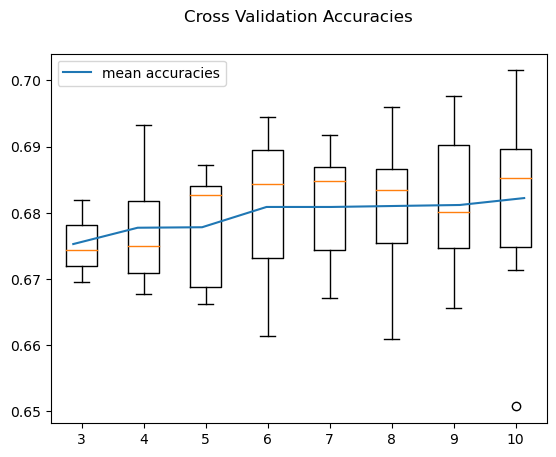

In [33]:
# plot cross validation accuracies
plt.boxplot(cross_validation_accs.values(), labels=list(range(3, 11)))
ax = plt.twiny()
avg_accs = [np.mean(accs) for accs in cross_validation_accs.values()]
ax.plot(avg_accs, label='mean accuracies')
ax.set_axis_off()
ax.legend(loc = 'upper left')
plt.title("Cross Validation Accuracies")

According to the graph above, it is clear that the 7-fold cross-validation has the best accuracies, considering the stablity and median accuracy. Hence, a rougly 86/14 split would be ideal for this dataset.

In [34]:
# use the optimal number of folds for the following analysis
cross_validator = KFold(n_splits=7)
split_indices = cross_validator.split(pca_feature, labels)

## 2. Modeling

#### 2.1 
Create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize. Ability to choose optimization technique when class is instantiated.
Update the gradient calculation to include a customizable regularization term.

In [35]:
import numpy as np


class BinaryLogisticRegressionBase:
    # private:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        # internally we will store the weights as self.w_ to keep with sklearn conventions

    def __str__(self):
        return 'Base Binary Logistic Regression Object, Not Trainable'

    # convenience, private and static:
    @staticmethod
    def _sigmoid(theta):
        return 1/(1+np.exp(-theta))

    @staticmethod
    def _add_intercept(X):
        return np.hstack((np.ones((X.shape[0], 1)), X))  # add bias term

    # public:
    def predict_proba(self, X, add_intercept=True):
        # add bias term if requested
        Xb = self._add_intercept(X) if add_intercept else X
        return self._sigmoid(Xb @ self.w_)  # return the probability y=1

    def predict(self, X):
        return (self.predict_proba(X) > 0.5)  # return the actual prediction


blr = BinaryLogisticRegressionBase(0.1)
print(blr)

Base Binary Logistic Regression Object, Not Trainable


In [36]:
# inherit from base class
class BinaryLogisticRegression(BinaryLogisticRegressionBase):
    # private:
    def __str__(self):
        if (hasattr(self, 'w_')):
            # is we have trained the object
            return 'Binary Logistic Regression Object with coefficients:\n' + str(self.w_)
        else:
            return 'Untrained Binary Logistic Regression Object'

    def _get_gradient(self, X, y):
        # programming \sum_i (yi-g(xi))xi
        gradient = np.zeros(self.w_.shape)  # set gradient to zero
        for (xi, yi) in zip(X, y):
            # the actual update inside of sum
            gradi = (yi - self.predict_proba(xi, add_intercept=False))*xi
            # reshape to be column vector and add to gradient
            gradient += gradi.reshape(self.w_.shape)

        return gradient/float(len(y))

    # public:
    def fit(self, X, y):
        Xb = self._add_intercept(X)  # add bias term
        num_samples, num_features = Xb.shape

        self.w_ = np.zeros((num_features, 1))  # init weight vector to zeros

        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb, y)
            self.w_ += gradient*self.eta  # multiply by learning rate


blr = BinaryLogisticRegression(0.1)
print(blr)

Untrained Binary Logistic Regression Object


In [37]:
# Train and test the model using datasets using different feature engineering methods to verify performance improvement

# # Use original data
X_train, X_test, y_train, y_test = train_test_split(features, labels>1, train_size=0.8, test_size=0.2, random_state=42)

blr = BinaryLogisticRegression(eta=0.1, iterations=12)
blr.fit(X_train, y_train)
print(blr)

yhat = blr.predict(X_test)
print('Accuracy of using original dataset: ', accuracy_score(y_test, yhat))
print("=====================================")


# Use PCA data without cross validation
X_train, X_test, y_train, y_test = train_test_split(pca_feature, labels>1, train_size=0.8, test_size=0.2, random_state=42)

blr = BinaryLogisticRegression(eta=0.1, iterations=12)
blr.fit(X_train, y_train)
print(blr)

yhat = blr.predict(X_test)
print('Accuracy of using PCA dataset: ', accuracy_score(y_test, yhat))
print("=====================================")



Binary Logistic Regression Object with coefficients:
[[ 0.00109463]
 [-0.00322765]
 [ 0.03427808]
 [ 0.08486472]
 [ 0.11756695]
 [ 0.0183248 ]
 [ 0.00110716]
 [-0.05532021]
 [-0.25294986]
 [-0.17958845]
 [-0.0943051 ]
 [-0.0414957 ]
 [ 0.0414957 ]]
Accuracy of using original dataset:  0.7771556550951848
Binary Logistic Regression Object with coefficients:
[[ 0.00109317]
 [ 0.04458127]
 [-0.2252972 ]
 [-0.2473322 ]
 [ 0.10332196]
 [-0.07203594]
 [-0.03337148]
 [ 0.00718589]
 [ 0.0548416 ]]
Accuracy of using PCA dataset:  0.7771556550951848


In [38]:
# Train the classifier with more iterations to check if the accuracy improves
params = dict(eta=0.01,
              iterations=500)


# Use original data
X_train, X_test, y_train, y_test = train_test_split(features, labels > 1, train_size=0.8, test_size=0.2, random_state=42)

blr = BinaryLogisticRegression(**params)
blr.fit(X_train, y_train)
print(blr)

yhat = blr.predict(X_test)
print('Accuracy of using original dataset: ', accuracy_score(y_test, yhat))
print("=====================================")


# Use PCA data without cross validation

X_train, X_test, y_train, y_test = train_test_split(pca_feature, labels > 1, train_size=0.8, test_size=0.2, random_state=42)

blr = BinaryLogisticRegression(**params)
blr.fit(X_train, y_train)
print(blr)

yhat = blr.predict(X_test)
print('Accuracy of using PCA dataset: ', accuracy_score(y_test, yhat))
print("=====================================")

Binary Logistic Regression Object with coefficients:
[[ 0.0171976 ]
 [-0.13503079]
 [ 0.12261499]
 [ 0.21883226]
 [ 0.26064048]
 [ 0.02528584]
 [-0.03388647]
 [-0.16337931]
 [-0.68768268]
 [-0.47088493]
 [-0.21516643]
 [-0.13099775]
 [ 0.13099775]]
Accuracy of using original dataset:  0.7973124300111982
Binary Logistic Regression Object with coefficients:
[[ 0.01711285]
 [ 0.06151229]
 [-0.50023012]
 [-0.68692673]
 [ 0.32376052]
 [-0.24934156]
 [-0.12075615]
 [ 0.0245485 ]
 [ 0.2028872 ]]
Accuracy of using PCA dataset:  0.799552071668533


**Observation**:
- The Binary Classification Model performs a similar level of accuracy when using the original dataset versus using a dataset that has undergone PCA (Principal Component Analysis). It means the principal components retained capture most of the variance and the essential characteristics crucial for effective classification.

- The accuracy improved after tuning the hyperparameter of interaction with an increased value for all datasets.

- It was also observed that as the interaction level was raised, the accuracy when using PCA-transformed data improved slightly compared to using the original data. This suggests that our dataset is likely to obtain better generalization for machine learning studies after applying Principal Component Analysis (PCA).

- We will continue to experiment with this approach in the training of the multiclass classifier to determine whether using two different datasets impacts performance in a multiclass classification problem.


Use numpy and scipy expit to optimize the Logistic Regression Function

In [39]:
# Vectorized Programming for Logistic Regression
import numpy as np
from scipy.special import expit

class VectorBinaryLogisticRegression(BinaryLogisticRegression):
    # inherit from our previous class to get same functionality
    @staticmethod
    def _sigmoid(theta):
        # increase stability using expit which is more stable
        return expit(theta)  # 1/(1+np.exp(-theta))

    # overwrite the gradient calculation
    def _get_gradient(self, X, y):
        # get y difference
        ydiff = y-self.predict_proba(X, add_intercept=False).ravel()
            # convert ydiff to a NumPy array
        ydiff = np.array(ydiff)
        # make ydiff a column vector and multiply through
        gradient = np.mean(X * ydiff[:, np.newaxis], axis=0)

        return gradient.reshape(self.w_.shape)


One-versus-all to program a Multicalss Logistic Regression

In [40]:
class LogisticRegression:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations

    def __str__(self):
        if (hasattr(self, 'w_')):
            # is we have trained the object
            return 'MultiClass Logistic Regression Object with coefficients:\n' + str(self.w_)
        else:
            return 'Untrained MultiClass Logistic Regression Object'

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y)  # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []  # will fill this array with binary classifiers

        for i, yval in enumerate(self.unique_):  # for each unique value
            y_binary = (y == yval)  # create a binary problem
            # train the binary classifier for this class
            blr = VectorBinaryLogisticRegression(self.eta,
                                                 self.iters)
            blr.fit(X, y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)

        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

    def predict_proba(self, X):
        probs = []
        for blr in self.classifiers_:
            # get probability for each classifier
            probs.append(blr.predict_proba(X))

        return np.hstack(probs)  # make into single matrix

    def predict(self, X):
        # take argmax along row
        return self.unique_[np.argmax(self.predict_proba(X), axis=1)]


lr = LogisticRegression(0.1, 1500)
print(lr)

Untrained MultiClass Logistic Regression Object


In [41]:
# Train and test the multiclassifer model using datasets using different feature engineering methods to verify performance improvement

# Use original data
X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.8, test_size=0.2, random_state=42)

blr = LogisticRegression(0.1, 500)
blr.fit(X_train, y_train)
print(blr)

yhat = blr.predict(X_test)
print('Accuracy of using original dataset: ', accuracy_score(y_test, yhat))
print("=====================================")


# Use PCA data 

X_train, X_test, y_train, y_test = train_test_split(pca_feature, labels, train_size=0.8, test_size=0.2, random_state=42)

blr = LogisticRegression(0.1, 500)
blr.fit(X_train, y_train)
print(blr)

yhat = blr.predict(X_test)
print('Accuracy of using PCA dataset: ', accuracy_score(y_test, yhat))
print("=====================================")

MultiClass Logistic Regression Object with coefficients:
[[-1.91801958  0.74968078 -0.22944868 -0.43992261 -0.29939116 -0.05469933
   0.03717653  0.62296605  1.34802534  1.21206523  0.50374463  0.47796967
  -0.47796967]
 [-1.17104521  0.22776819 -0.01004329 -0.17018946 -0.03079478 -0.05262035
   0.0661083   0.10525525  0.39972543  0.28677999  0.02924323 -0.01998878
   0.01998878]
 [-1.11820814 -0.15931746  0.27084148 -0.27182703 -0.12156112  0.01318999
  -0.01738208 -0.18422125 -0.00943049 -0.24709648 -0.19896711 -0.20597979
   0.20597979]
 [-1.81588694 -0.72759273  0.03423097  0.78949416  0.63400521  0.0983367
  -0.05746709 -0.44685188 -1.47840601 -1.25980602 -0.27719258 -0.2579491
   0.2579491 ]]
Accuracy of using original dataset:  0.5882792086599478
MultiClass Logistic Regression Object with coefficients:
[[-1.91117084 -0.05689814  0.88899762  1.43258541 -0.7386978   0.77344192
   0.41363663 -0.03615732 -0.94269326]
 [-1.16938649 -0.04266054  0.1559793   0.34211662 -0.27473308  0.2

**Observation:** 
- The multiclass classifier maintains a similar level of accuracy across both the original and the PCA-transformed datasets. This further confirms that the principal components retained encapsulate the majority of the variance and the essential characteristics crucial for effective classification. Therefore, we will proceed with our analysis using the PCA-transformed data in the subsequent steps.
- The consistent accuracy across various datasets suggests that the model generalizes well. However, the accuracy rate is approximately 0.58, which is considerably low. We will continue exploring ways to see if we can improve the model's accuracy.


Logistic Regression Class Boundaries

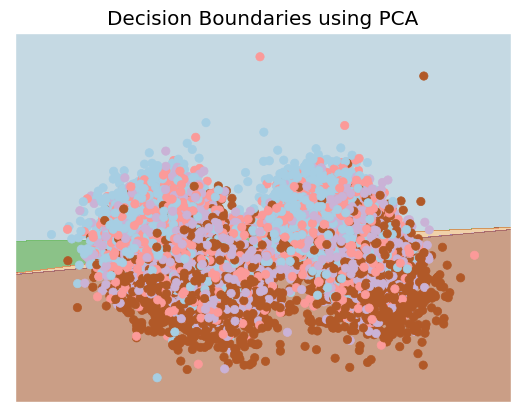

In [60]:
# linear boundaries visualization from sklearn documentation
from matplotlib import pyplot as plt
import copy
%matplotlib inline
plt.style.use('ggplot')

def plot_decision_boundaries(lr,Xin,y,title=''):
    Xb = copy.deepcopy(Xin)
    lr.fit(Xb[:,:2],y) # train only on two features

    h=0.01
    # create a mesh to plot in
    x_min, x_max = Xb[:, 0].min() - 1, Xb[:, 0].max() + 1
    y_min, y_max = Xb[:, 1].min() - 1, Xb[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # get prediction values
    Z = lr.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.5)

    # Plot also the training points
    plt.scatter(Xb[:, 0], Xb[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlabel('')
    plt.ylabel('')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    plt.show()
    
lr = LogisticRegression(0.1,1500) # OUR LR implementation
plot_decision_boundaries(lr,pca_feature,labels,title='Decision Boundaries using PCA')

Introduce the L2-Norm parameter into the objective function to maintain relatively small weight values, aiming to mitigate overfitting. Modify the objective function by incorporating a new summation term for the weights, which reduces their maximum values when the weights become large.

To apply this theory, utilize C as the hyperparameter to balance the optimization of the previous function with the objective of maintaining small weights.


In [61]:
class RegularizedBinaryLogisticRegression(VectorBinaryLogisticRegression):
    # extend init functions
    def __init__(self, C=0.0, **kwds):
        # need to add to the original initializer
        self.C = C
        # but keep other keywords
        super().__init__(**kwds)  # call parent initializer

    # extend previous class to change functionality
    def _get_gradient(self, X, y):
        # call get gradient from previous class
        gradient = super()._get_gradient(X, y)

        # add in regularization (to all except bias term)
        gradient[1:] += -2 * self.w_[1:] * self.C
        return gradient

In [62]:
# now redefine the Logistic Regression Function where needed
class RegularizedLogisticRegression(LogisticRegression):
    def __init__(self, C=0.0, **kwds):        
        self.C = C
        super().__init__(**kwds)
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) 
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            blr = RegularizedBinaryLogisticRegression(eta=self.eta,
                                                      iterations=self.iters,
                                                      C=self.C)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        # now redefine the Logistic Regression Function where needed
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

In [63]:
from ipywidgets import widgets as wd

cost_vals = np.logspace(-3, 1, 15) # 15 values from 0.001 to 10


def lr_explor(cost_idx): 
    C = cost_vals[cost_idx]
    lr_clf = RegularizedLogisticRegression(eta=0.1,
                                           # lots of iterations (to help overfit)
                                           iterations=2500,
                                           C=C)  # get object

    plot_decision_boundaries(lr_clf, pca_feature, labels, title="C=%.5f" % (C))
    plt.show()


wd.interact(lr_explor, cost_idx=(0, 14, 1), __manual=True)

# what happens when C gets too large??
# let's explore the different values and see what happens

interactive(children=(IntSlider(value=7, description='cost_idx', max=14), Output()), _dom_classes=('widget-int…

<function __main__.lr_explor(cost_idx)>

###  Implemente optimization techniques
- Use a line search along gradient direction to find the right value of eta
    - Optimize eta, with all inputs constant
    - Do line search in gradient direction, using scipy function
    - Scipy minimize_scaler to optimize the obeject function, bounds and speed
    - Get the optimal learning rate
- Update the gradient calculation to include a customizable regularization term using L2 
 regularization. Set up **C** that can be adjusted when the class is instantiated.  
- Recall: For logistic regression, the regularization term "C" plays a crucial role in controlling overfitting and underfitting as it controls how the gridents will move.

- Experimenting with various solver methods— stochastic gradient ascent, and Newton's method—when the class is instantiated

In [64]:
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions

    def __str__(self):
        if (hasattr(self, 'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n' + str(self.w_)
        else:
            return 'Untrained Binary Logistic Regression Object'

    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0], 1)), X))  # add bias term

    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta)  # 1/(1+np.exp(-theta))

    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self, X, y):
        # get y difference
        ydiff = y-self.predict_proba(X, add_bias=False).ravel()
        # convert ydiff to a NumPy array
        ydiff = np.array(ydiff)
        # make ydiff a column vector and multiply through
        gradient = np.mean(X * ydiff[:, np.newaxis], axis=0)
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C

        return gradient

    # public:
    def predict_proba(self, X, add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_)  # return the probability y=1

    def predict(self, X):
        return (self.predict_proba(X) > 0.5)  # return the actual prediction

    def fit(self, X, y):
        Xb = self._add_bias(X)  # add bias term
        num_samples, num_features = Xb.shape

        self.w_ = np.zeros((num_features, 1))  # init weight vector to zeros

        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb, y)
            self.w_ += gradient*self.eta  # multiply by learning rate
            # add bacause maximizing



In [65]:
%%time
# Use PCA data without cross validation

X_train, X_test, y_train, y_test = train_test_split(
    pca_feature, labels > 1, train_size=0.8, test_size=0.2, random_state=42)

blr = BinaryLogisticRegression(eta=0.1, iterations=50, C=0.001)


blr.fit(X_train, y_train)
print(blr)

yhat = blr.predict(X_test)

print('Accuracy of: ', accuracy_score(y_test, yhat))

Binary Logistic Regression Object with coefficients:
[[ 0.01708465]
 [ 0.06148686]
 [-0.50122078]
 [-0.68806271]
 [ 0.32399782]
 [-0.24921249]
 [-0.12053534]
 [ 0.02451663]
 [ 0.20238971]]
Accuracy of:  0.7991787980589772
Wall time: 74.4 ms


In [66]:
%%time
#use a line search along the gradient direction:
from scipy.optimize import minimize_scalar
import copy
# (masked array) this has most numpy functions that work with NaN data.
from numpy import ma


class LineSearchLogisticRegression(BinaryLogisticRegression):

    # define custom line search for problem
    def __init__(self, line_iters=0.0, **kwds):
        self.line_iters = line_iters
        # but keep other keywords
        super().__init__(**kwds)  # call parent initializer

    # this defines the function with the first input to be optimized
    # therefore eta will be optimized, with all inputs constant
    @staticmethod
    def objective_function(eta, X, y, w, grad, C):
        wnew = w - grad*eta
        g = expit(X @ wnew)
        # the line search is looking for minimization, so take the negative of l(w)
        return -np.sum(ma.log(g[y == 1]))-ma.sum(ma.log(1-g[y == 0])) + C*sum(wnew**2)

    def fit(self, X, y):
        Xb = self._add_bias(X)  # add bias term
        num_samples, num_features = Xb.shape

        self.w_ = np.zeros((num_features, 1))  # init weight vector to zeros

        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = -self._get_gradient(Xb, y)
            # minimization is in opposite direction

            # do line search in gradient direction, using scipy function
            # unclear exactly what this should be
            opts = {'maxiter': self.line_iters}
            res = minimize_scalar(self.objective_function,  # objective function to optimize
                                  # bounds to optimize
                                  bounds=(0, self.eta*10),
                                  # additional argument for objective function
                                  args=(Xb, y, self.w_, gradient, self.C),
                                  method='bounded',  # bounded optimization for speed
                                  options=opts)  # set max iterations

            eta = res.x  # get optimal learning rate
            self.w_ -= gradient*eta  # set new function values
            # subtract to minimize


lslr = LineSearchLogisticRegression(eta=1.0,
                                    iterations=6,
                                    line_iters=8,
                                    C=0.001)

lslr.fit(X_train, y_train)

yhat = lslr.predict(X_test)
print("eta: ", lslr.eta)
print(lslr)
print('Accuracy of: ', accuracy_score(y_test,yhat))         

eta:  1.0
Binary Logistic Regression Object with coefficients:
[[ 0.10637941]
 [ 0.04375375]
 [-0.7485619 ]
 [-1.24122836]
 [ 0.67076075]
 [-0.56642281]
 [-0.28217899]
 [ 0.04729982]
 [ 0.4776516 ]]
Accuracy of:  0.8167226577081
Wall time: 103 ms


**Observation:** Performance has improved slightly after using Line Search, but not too much faster, mostly because $\eta$ was chosen well in the initial example

### Stochastic Gradient Descent
When calculating the gradient becomes too computationally intensive with large datasets, we can approximate the gradient using a single instance, with the underlying theory supporting the notion that the steps may appear somewhat random

In [67]:
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation
    def _get_gradient(self, X, y):

        # grab a subset of samples in a mini-batch
        # and calculate the gradient according to the small batch only
        mini_batch_size = 16
        idxs = np.random.choice(len(y), mini_batch_size)

        # get y difference (now scalar)
        ydiff = y[idxs]-self.predict_proba(X[idxs], add_bias=False).ravel()
        # convert ydiff to a NumPy array
        ydiff = np.array(ydiff)
        # make ydiff a column vector and multiply through
        gradient = np.mean(X[idxs] * ydiff[:, np.newaxis], axis=0)

        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C

        return gradient


X_train, X_test, y_train, y_test = train_test_split(
    pca_feature, labels > 1, train_size=0.8, test_size=0.2, random_state=42)

slr = StochasticLogisticRegression(eta=0.01, iterations=300, C=0.001)  # take a lot more steps!!

slr.fit(X_train, y_train.to_numpy())

yhat = slr.predict(X_test)
print(slr)
print('Accuracy of: ', accuracy_score(y_test,yhat))      


Binary Logistic Regression Object with coefficients:
[[ 0.02710014]
 [ 0.06615381]
 [-0.38164494]
 [-0.50989686]
 [ 0.22286003]
 [-0.1546496 ]
 [-0.07087731]
 [ 0.01534709]
 [ 0.12334199]]
Accuracy of:  0.7894736842105263


### Newton's Update Method - Hessian
- In multiple dimensions when dealing with functions of several variables, this involves using the Hessian matrix (a square matrix of second-order partial derivatives of the function) and the gradient of the function. This method is used to find points where the function reaches its local maxima or minima. The inclusion of the Hessian allows Newton's method to consider the curvature of the function, potentially leading to faster convergence compared to methods that only use the first derivative, such as Gradient Descent.

References:
- https://www.quora.com/Why-is-Newtons-method-only-appropriate-when-the-Hessian-is-positive-definite
- https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/quadratic-approximations/a/the-hessian



In [69]:
# code Hessian up using numpy:

from numpy.linalg import pinv


class HessianBinaryLogisticRegression(BinaryLogisticRegression):
    # just overwrite gradient function
    def _get_gradient(self, X, y):
        # get sigmoid value for all classes
        g = self.predict_proba(X, add_bias=False).ravel()
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * \
            self.C  # calculate the hessian

        ydiff = y-g  # get y difference
        # convert ydiff to a NumPy array
        ydiff = np.array(ydiff)
        # make ydiff a column vector and multiply through
        gradient = np.sum(X * ydiff[:, np.newaxis], axis=0)
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C

        return pinv(hessian) @ gradient


hlr = HessianBinaryLogisticRegression(eta=1.0,
                                      iterations=4,
                                      C=0.001)  # note that we need only a few iterations here

hlr.fit(X_train, y_train)
yhat = hlr.predict(X_test)
print(hlr)
print('Accuracy of: ', accuracy_score(y_test,yhat))


Binary Logistic Regression Object with coefficients:
[[ 0.25864146]
 [ 0.106703  ]
 [-1.01329193]
 [-1.77227632]
 [ 1.04971677]
 [-1.01372997]
 [-0.69865771]
 [ 0.09431737]
 [ 1.5519017 ]]
Accuracy of:  0.8223217618514371


**Observation:**
- Stochastic Gradient Descent exhibits relatively lower accuracy compared to other methods. The Newton's Update method, utilizing the Hessian matrix, performs the best, achieving the highest accuracy. 
- It indicatrs, with the nature of our current dataset, Newton's updated method is likely to offer faster convergence and potentially more accurate updates by adjusting the learning steps based on the curvature of the error surface (Hessian matrix) across the full dataset.
- Therefore, it is advisable to construct the Multiclass Classifier using the Hessian-based approach for enhanced performance.

In [70]:

from scipy.optimize import fmin_bfgs
from scipy.optimize import fmin_bfgs
from numpy import ma


class BFGSBinaryLogisticRegression(BinaryLogisticRegression):

    @staticmethod
    def objective_function(w, X, y, C):
        g = expit(X @ w)
        # invert this because scipy minimizes, but we derived all formulas for maximzing
        return -ma.sum(ma.log(g[y == 1]))-ma.sum(ma.log(1-g[y == 0])) + C*sum(w**2)
        # -np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w, X, y, C):
        g = expit(X @ w)
        ydiff = y-g  # get y difference
        # convert ydiff to a NumPy array
        ydiff = np.array(ydiff)
        gradient = np.mean(X * ydiff[:, np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += -2 * w[1:] * C
        return -gradient

    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X)  # add bias term
        num_samples, num_features = Xb.shape

        self.w_ = fmin_bfgs(self.objective_function,  # what to optimize
                            np.zeros((num_features, 1)),  # starting point
                            fprime=self.objective_gradient,  # gradient function
                            # extra args for gradient and objective function
                            args=(Xb, y, self.C),
                            gtol=1e-03,  # stopping criteria for gradient, |v_k|
                            maxiter=self.iters,  # stopping criteria iterations
                            disp=False)

        self.w_ = self.w_.reshape((num_features, 1))


# note that we need only a few iterations here
bfgslr = BFGSBinaryLogisticRegression(_, iterations=3, C=0.001)

bfgslr.fit(X_train, y_train)
yhat = bfgslr.predict(X_test)
print(bfgslr)
print('Accuracy of: ', accuracy_score(y_test,yhat))

Binary Logistic Regression Object with coefficients:
[[ 0.02266496]
 [ 0.07481617]
 [-0.79533154]
 [-1.07812974]
 [ 0.4908105 ]
 [-0.36232924]
 [-0.16957945]
 [ 0.03492747]
 [ 0.28067543]]
Accuracy of:  0.7980589772303098


In [71]:
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20,
                 C=0.0001,
                 solver=BFGSBinaryLogisticRegression):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.solver = solver
        self.classifiers_ = []
        # internally we will store the weights as self.w_ to keep with sklearn conventions

    def __str__(self):
        if (hasattr(self, 'w_')):
            # is we have trained the object
            return 'MultiClass Logistic Regression Object with coefficients:\n' + str(self.w_)
        else:
            return 'Untrained MultiClass Logistic Regression Object'

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y))  # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i, yval in enumerate(self.unique_):  # for each unique value
            y_binary = np.array(y == yval).astype(
                int)  # create a binary problem
            # train the binary classifier for this class

            hblr = self.solver(eta=self.eta, iterations=self.iters, C=self.C)
            hblr.fit(X, y_binary)

            # add the trained classifier to the list
            self.classifiers_.append(hblr)

        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

    def predict_proba(self, X):
        probs = []
        for hblr in self.classifiers_:
            # get probability for each classifier
            probs.append(hblr.predict_proba(X).reshape((len(X), 1)))

        return np.hstack(probs)  # make into single matrix

    def predict(self, X):
        return self.unique_[np.argmax(self.predict_proba(X), axis=1)] # take argmax along row

In [72]:
# train the MultiClass classifier
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, train_size=0.8, test_size=0.2, random_state=42)

lr = MultiClassLogisticRegression(eta=1.0,
                                  iterations=5,
                                  C=0.001,
                                  solver=HessianBinaryLogisticRegression
                                  )
lr.fit(X_train, y_train)
print(lr)

yhat = lr.predict(X_test)
print('Accuracy of: ', accuracy_score(y_test, yhat))

MultiClass Logistic Regression Object with coefficients:
[[-2.54939119e+00  1.37143524e+00  4.08114921e-02 -1.09320247e+00
  -9.30949836e-03 -1.12186373e-01  5.40714959e-02  1.18535742e+00
   1.68997947e+00  1.89788019e+00  8.75816038e-01 -4.37527212e+00
  -5.93041087e+00]
 [-1.17599724e+00  2.45022510e-01  5.33061109e-02 -2.57175657e-01
   3.38004686e-02 -6.07485809e-02  7.15542201e-02  1.34435130e-01
   4.02454947e-01  3.22572407e-01  1.49709093e-02  6.76695525e-01
   7.37366013e-01]
 [-1.12586759e+00 -1.81228824e-01  3.43989993e-01 -3.65290215e-01
  -6.44526108e-02  8.36591128e-03 -1.09584524e-02 -1.77164361e-01
   1.84458260e-02 -2.54925974e-01 -2.42032095e-01  4.62802808e+00
   5.12340578e+00]
 [-2.18228966e+00 -1.19908183e+00 -3.45841559e-01  1.41150438e+00
   4.34334036e-01  1.39972297e-01 -6.38034252e-02 -8.39643493e-01
  -1.70529083e+00 -1.97616237e+00 -2.43401218e-01  1.12730783e+01
   1.21375793e+01]]
Accuracy of:  0.5994774169466218


**Observation:**
The accuracy has not improved significantly. It improved slightly from 0.589 to approximately 0.599 after applying Hessian optimization with SciPy to the objective-oriented logistic function. 

### 2.2 Train your classifier to achieve good generalization performance. 
Ajust the optimization technique and the value of the regularization term(s) "C" to achieve the best performance on the test set.
Visualize the performance of the classifier versus the parameters that is investigated.


In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, train_size=0.8, test_size=0.2, random_state=42)

# Set up the range of "C" values to explore
C_vals = np.logspace(-3, 3, 15)  # from 0.001 to 1000
best_accuracy = 0
best_C = None
accuracies = []  # List to store the accuracy for each value of C

# Iterate over all values of C
for C in C_vals:
    lr = MultiClassLogisticRegression(eta=1.0,
                                      iterations=5,
                                      C=C,
                                      solver=HessianBinaryLogisticRegression
                                      )
    lr.fit(X_train, y_train)
    yhat = lr.predict(X_test)
    accuracy = accuracy_score(y_test, yhat)
    accuracies.append(accuracy)
    print(f"C={C}: Validation Accuracy={accuracy:.3f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_C = C
        
# Retrain the model using the best C value
lr = MultiClassLogisticRegression(eta=1.0,
                                  iterations=5,
                                  C=best_C,
                                  solver=HessianBinaryLogisticRegression
                                  )
lr.fit(X_train, y_train)
yhat = lr.predict(X_test)
final_accuracy = accuracy_score(y_test, yhat)
print(f"Best C={best_C}: Test Set Accuracy={final_accuracy}")

C=0.001: Validation Accuracy=0.599
C=0.0026826957952797246: Validation Accuracy=0.599
C=0.0071968567300115215: Validation Accuracy=0.599
C=0.019306977288832496: Validation Accuracy=0.599
C=0.0517947467923121: Validation Accuracy=0.599
C=0.13894954943731375: Validation Accuracy=0.599
C=0.3727593720314938: Validation Accuracy=0.599
C=1.0: Validation Accuracy=0.598
C=2.6826957952797246: Validation Accuracy=0.595
C=7.196856730011514: Validation Accuracy=0.588
C=19.306977288832496: Validation Accuracy=0.572
C=51.794746792312125: Validation Accuracy=0.546
C=138.9495494373136: Validation Accuracy=0.342
C=372.7593720314938: Validation Accuracy=0.270
C=1000.0: Validation Accuracy=0.181
Best C=0.001: Test Set Accuracy=0.5994774169466218


Visualize the performance of the classifier versus the "C" parameter

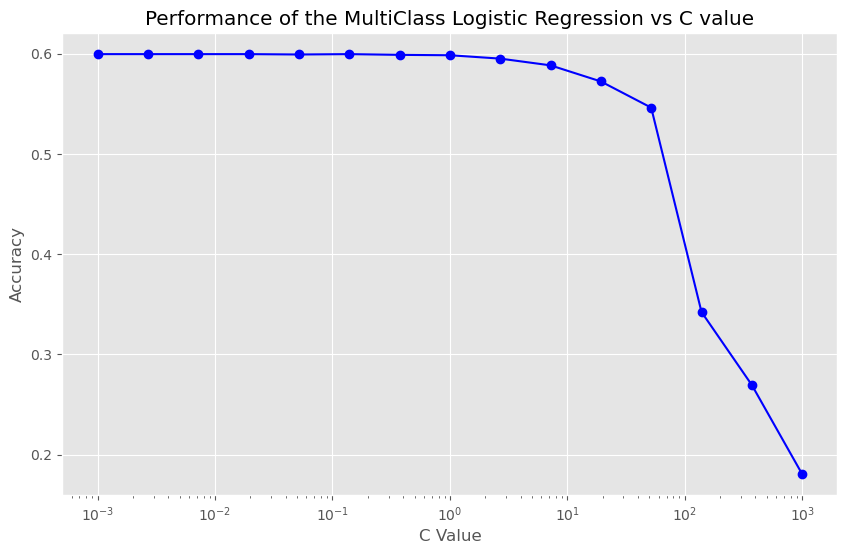

In [74]:
import matplotlib.pyplot as plt

# Plot the accuracy vs C values
plt.figure(figsize=(10, 6))
plt.plot(C_vals, accuracies, marker='o', linestyle='-', color='b')
plt.xscale('log') # Because C values are in log scale
plt.title('Performance of the MultiClass Logistic Regression vs C value')
plt.xlabel('C Value')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

**Observation: **
- **High Accuracy with lower C values:** It can observed apparently from the visualization that the performance of the Multiclass Logistic Regression model maintained a consistently high accuracy (at a level range between 0.60 and 0.55) for values of “C” ranging from 0.001 to around 10. 

- **Sharp Drop in Accuracy:** There is a sharp drop in accuracy as "C" increases beyond 10. This suggests that reducing regularization beyond a certain point (i.e., making "C" too large) leads to overfitting. The model starts to fit the noise in the training data, which harms its performance on the validation set.

- **Optimal Range of "C":** The optimal range of "C" appears to be between approximately 0.001 and 10, where the model achieves the highest validation accuracy. This suggests that the model performance is robust with a relatively smaller C value with more regularization. This is the range (0.001 and 10) we should consider for the best balance between bias and variance, leading to better generalization on unseen data.

- **Choosing the Best "C":** Based on this graph, we should choose a "C" value within the range where the model maintains high accuracy before the sharp drop. This ensures the model is regularized appropriately to generalize well without overfitting.

In conclusion, to achieve the best generalization performance on unseen data, we should select a "C" value within the optimal range identified above.

#### Questions:
**Is your method of selecting parameters justified?**
- The method of selecting parameters should be justified based on whether it allows for the generalization of the model to unseen data without introducing bias or overfitting. From the practices we conducted, there appears to be a methodical approach to tuning parameters, which is a good practice. 
- The careful selection of the "C" parameter, as executed, shows an awareness of the balance between bias and variance, which is crucial for model generalization. The observation that there is an optimal range for "C" and that going beyond this range leads to overfitting is an important insight that suggests a thoughtful approach to parameter tuning.


**That is, do you think there is any "data snooping" involved with this method of selecting parameters?**
- The concept of "data snooping" refers to the practice of using the same dataset to both tune the parameters of a model and evaluate its performance. If the parameter selection is heavily influenced by the specifics of the test data, this could lead to overfitting and less generalizable results.

- The concept of "data snooping" refers to the practice of using the same dataset to both tune the parameters of a model and evaluate its performance. If the parameter selection is heavily influenced by the specifics of the test data, this could lead to overfitting and less generalizable results.

- From the observations of the outcomes, there does not seem to be evidence of "data snooping".

- Our approach's consistency, applying the cross-validation process, PCA, and adjusting parameters, supports a disciplined method in avoiding data snooping, assuming the final evaluations are correctly segregated.


Overall, our applied method and outcomes seem to adhere to good practices in machine learning, aiming for generalization and avoiding data snooping, provided that the datasets for parameter tuning and final evaluation are kept separate.

### 2.3 Performance Comparison with Scikit-learn

In [28]:
%%time
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
lr_sk = SKLogisticRegression(max_iter=1000) # all params default
lr_sk.fit(X_train,y_train)
print(np.hstack((lr_sk.intercept_[:,np.newaxis],lr_sk.coef_)))
yhat = lr_sk.predict(X_test)

accuracy = accuracy_score(y_test, yhat)

print("Accuracy of SciKit Learn:", accuracy)

[[ 0.23697413  0.09992083 -1.00092125 -1.74918855  1.05353977 -0.98484111
  -0.67578183  0.05062958  1.49264595]]
Accuracy of SciKit Learn: 0.8332462101411395
CPU times: user 76.2 ms, sys: 11.1 ms, total: 87.3 ms
Wall time: 14.2 ms


In [37]:
%%time
lr = MultiClassLogisticRegression(eta=1.0,
                                  iterations=5,
                                  C=2.68269,
                                  solver=HessianBinaryLogisticRegression
                                  )
lr.fit(X_train, y_train)
print(lr)

yhat = lr.predict(X_test)
print('Accuracy of Multiclass Logistic Regression with Hessian: ', accuracy_score(y_test, yhat))

MultiClass Logistic Regression Object with coefficients:
[[-0.23255028 -0.09890698  0.98980971  1.72742943 -1.03881455  0.97058076
   0.66317249 -0.04970248 -1.45872832]
 [ 0.23255028  0.09890698 -0.98980971 -1.72742943  1.03881455 -0.97058076
  -0.66317249  0.04970248  1.45872832]]
Accuracy of Multiclass Logistic Regression with Hessian:  0.8348144276006273
CPU times: user 11.5 s, sys: 4.09 s, total: 15.6 s
Wall time: 2.38 s


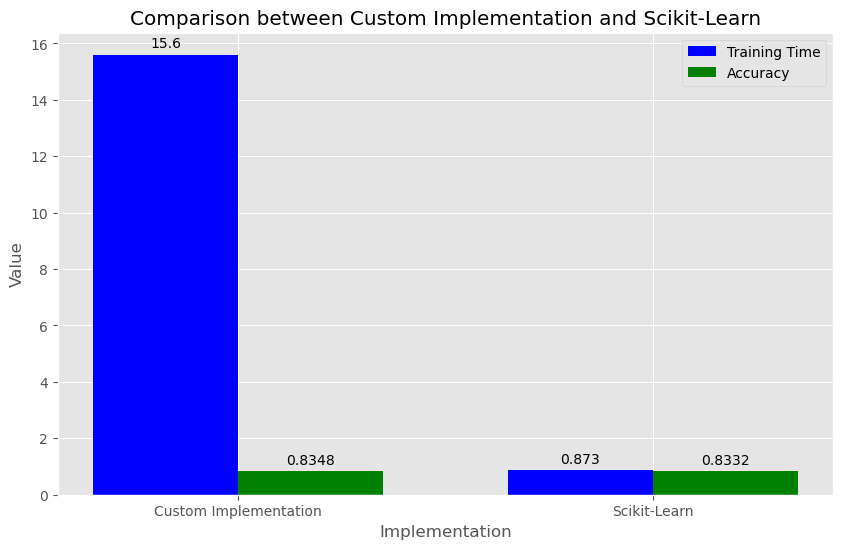

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Define the data
labels = ['Custom Implementation', 'Scikit-Learn']
training_times = [15.6, 0.873]  # Custom implementation, scikit-learn
accuracies = [0.8348, 0.8332]  # Custom implementation, scikit-learn

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot training times
rects1 = ax.bar(x - width/2, training_times, width, label='Training Time', color='blue')

# Plot accuracies
rects2 = ax.bar(x + width/2, accuracies, width, label='Accuracy', color='green')

# Add labels, title, and legend
ax.set_xlabel('Implementation')
ax.set_ylabel('Value')
ax.set_title('Comparison between Custom Implementation and Scikit-Learn')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels on top of the bars
def add_value_labels(ax, rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(ax, rects1)
add_value_labels(ax, rects2)

plt.show()

Scikit-learn's logistic regression is multitudes faster (0.873 ms) then our best custom regression optimization techniques (15.6 s). Both have relatively good accuracy at ~0.83.

## 3. Deployment

Since we are utilizing this data to predict a body's performance and tailor to someone's personal training needs, a robust and well-tested model must be utilized. Therefore, we recommend utilizing scikit-learn's logistic regression model. Not only does it have great optimization techniques, it is well established and would create an easier pipeline in the machine learning algorithims, leading to less numerical instabilities or maintenance issues down the line. 

## 4. Exceptional Work

### Mean Squared Error (MSE) Approach 

In logistic regression, the Mean Squared Error (MSE) approach minimizes the squared difference between predicted probabilities and actual labels.

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2
$$

The gradient of the MSE loss with respect to the weights is computed as:

$$
\nabla l(\mathbf{w}) = \frac{1}{N} \mathbf{X}^T (\mathbf{y} - \hat{\mathbf{y}})
$$

where:
- $\mathbf{X}$ is the design matrix
- $\mathbf{y}$ is the true labels
- $\hat{\mathbf{y}}$ is the predicted labels

We compute the gradient of the MSE loss function with respect to the model parameters and update the parameters iteratively until convergence.


In [31]:
class LogisticRegressionMSE:
    def __init__(self, eta, C=1.0, iterations=20):
        self.eta = eta
        self.C = C  # Regularization parameter
        self.iters = iterations
        self.weights = None  # Initialize weights
        
    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.w_ = np.zeros((num_features + 1, 1))
        X = np.c_[np.ones((num_samples, 1)), X]  # Add intercept
        
        for _ in range(self.iters):
            y_pred = self._sigmoid(X @ self.w_)
            y_pred = y_pred.flatten()
            gradient = X.T @ (y_pred - y) / num_samples
            hessian = X.T @ X / num_samples + np.diag([self.C] * (num_features + 1))  # Add regularization to Hessian
            gradient = gradient.reshape(-1, 1) # Reshape gradient to ensure it's treated as a column vector
            self.w_ -= self.eta * np.linalg.inv(hessian) @ gradient # Update the model parameters using Newton's method
        
        self.weights = self.w_  # Store weights
    
    def predict_proba(self, X):
        X = np.c_[np.ones((X.shape[0], 1)), X]
        return self._sigmoid(X @ self.w_)
    
    def predict(self, X):
        probabilities = self.predict_proba(X)
        return (probabilities >= 0.5).astype(int)
    
    def _sigmoid(self, z):
        z_clipped = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z_clipped))


In [32]:
%%time
lr_mse = LogisticRegressionMSE(eta=1, C=2.68269, iterations=5)

lr_mse.fit(X_train, y_train)
y_pred = lr_mse.predict(X_test)
print(np.vstack((lr_mse.weights[0], lr_mse.weights[1:])))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Logistic Regression MSE:", accuracy)


[[-0.00063576]
 [ 0.03126832]
 [-0.20711313]
 [-0.26349092]
 [ 0.11935669]
 [-0.08740166]
 [-0.04392327]
 [ 0.00611131]
 [ 0.07889322]]
Accuracy of Logistic Regression MSE: 0.7992681651855724
CPU times: user 39.9 ms, sys: 20.9 ms, total: 60.8 ms
Wall time: 8.4 ms


Now let's make a class with One Vs. Rest Multiclass with MSE

In [33]:
class LogisticRegressionMSEOvR:
    def __init__(self, eta, C=1.0, iterations=20):
        self.eta = eta
        self.C = C  # Regularization parameter
        self.iters = iterations
        self.classifiers = {}  # Dictionary to store binary classifiers
        
    def fit(self, X, y):
        num_samples, num_features = X.shape
        unique_classes = np.unique(y)
        
        for class_label in unique_classes:
            y_binary = (y == class_label).astype(int)  # Convert to binary labels
            classifier = LogisticRegressionMSE(self.eta, self.C, self.iters)  # Pass C parameter
            classifier.fit(X, y_binary)
            self.classifiers[class_label] = classifier
    
    def predict_proba(self, X):
        num_samples = X.shape[0]
        probabilities = np.zeros((num_samples, len(self.classifiers)))
        
        for i, (class_label, classifier) in enumerate(self.classifiers.items()):
            probabilities[:, i] = classifier.predict_proba(X).flatten()
        
        return probabilities
    
    def predict(self, X):
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)


In [34]:
%%time
lr_ovr = LogisticRegressionMSEOvR(eta=1, iterations=5, C=2.68269)
lr_ovr.fit(X_train, y_train)
y_pred = lr_ovr.predict(X_test)
weights_stacked = np.hstack([lr_ovr.classifiers[class_label].weights for class_label in lr_ovr.classifiers])
print(weights_stacked)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Logistc Regression MSE One Over Rest:", accuracy)

[[ 0.00063576 -0.00063576]
 [-0.03126832  0.03126832]
 [ 0.20711313 -0.20711313]
 [ 0.26349092 -0.26349092]
 [-0.11935669  0.11935669]
 [ 0.08740166 -0.08740166]
 [ 0.04392327 -0.04392327]
 [-0.00611131  0.00611131]
 [-0.07889322  0.07889322]]
Accuracy of Logistc Regression MSE One Over Rest: 0.7992681651855724
CPU times: user 78.6 ms, sys: 26.3 ms, total: 105 ms
Wall time: 14.2 ms


In [36]:
%%time
lr = MultiClassLogisticRegression(eta=1.0,
                                  iterations=5,
                                  C=2.68269,
                                  solver=HessianBinaryLogisticRegression
                                  )
lr.fit(X_train, y_train)
print(lr)

yhat = lr.predict(X_test)
print('Accuracy of Multiclass Logistic Regression with Hessian: ', accuracy_score(y_test, yhat))


MultiClass Logistic Regression Object with coefficients:
[[-0.23255028 -0.09890698  0.98980971  1.72742943 -1.03881455  0.97058076
   0.66317249 -0.04970248 -1.45872832]
 [ 0.23255028  0.09890698 -0.98980971 -1.72742943  1.03881455 -0.97058076
  -0.66317249  0.04970248  1.45872832]]
Accuracy of Multiclass Logistic Regression with Hessian:  0.8348144276006273
CPU times: user 9.8 s, sys: 3.9 s, total: 13.7 s
Wall time: 2.08 s


Between maxiumum likelihood estimation (MLE) and mean-squared error (MSE), we prefer MLE, due to it's ability to find the parameter values that make our model's predictions match the observed outcomes as closely as possible, as shown with the accuracy of ~0.80 for both binary logistic regression and multiclass logistic regression with MSE, and 0.83 accuracy for the multiclass logistic regression utilizing MLE. 

References:
1. https://www.kaggle.com/datasets/kukuroo3/body-performance-data
2. https://www.bigdata-culture.kr/bigdata/user/data_market/detail.do?id=ace0aea7-5eee-48b9-b616-637365d665c1
3. https://www.quora.com/Why-is-Newtons-method-only-appropriate-when-the-Hessian-is-positive-definite
4. https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/quadratic-approximations/a/the-hessian